In [544]:
# --- Importe suas classes ---
# (Assumindo que estão no PYTHONPATH ou na mesma pasta)
from equation.option_pricing import BlackScholes
from optimize.option_princing import BlackScholeOptimizer
from method.nn import MLP, ResNet
from method.hnn import HybridCQN 
from method.qnn import QuantumNeuralNetwork
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch as tc
import torch.nn as nn
import numpy as np
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from utils.save import *



In [545]:
# =============================================================================
# 0. CONFIGURAÇÃO
# =============================================================================

# Métrica principal para avaliar os modelos (use a desnormalizada)
MSE_COLUMN = 'mse_teste_desnormalizado'
LOSS_COLUMN = 'mean_last_100_loss' # ou 'mean_last_100_loss'

# Constantes de normalização (as mesmas usadas no treino)
S_max = 160.0
T = 1.0
V_max = 140.0

In [546]:
# =============================================================================
# 1. CARREGAR OS DADOS DO SUMÁRIO
# =============================================================================

all_dfs = []
summary = [SUMMARY_CLASSIC_PATH, SUMMARY_HYBRID_PATH, SUMMARY_QUANTUM_PATH, SUMMARY_CQUANTUM_PATH, SUMMARY_CHYBRID_PATH]

for summar in summary:
    all_dfs.append(pd.read_csv(summar))


df_all = pd.concat(all_dfs, ignore_index=True)

valid_seeds = [1924, 1925, 1926, 1973, 2024]
df_all = df_all[
    (df_all["seed"].isin(valid_seeds))  # filtragem pelas seeds
]

In [547]:
df_class = df_all[
    (df_all["model_type"] == "MLP") &
    (df_all["hidden"].isin([2, 3, 5])) &
    (df_all["blocks"].isin([1, 3, 5]))
    ].drop_duplicates()

df_class = df_class.drop_duplicates(subset=["hidden", "blocks", "seed"])

df_hybrid = df_all[(df_all["model_type"] == "HQNN") &
    (df_all["n_qubits"] == 5) &
    (df_all["entangler"] == "strong")
    ].drop_duplicates()

#df_hybrid = df_hybrid.drop_duplicates(subset=["hidden", "blocks", "seed"])

df_quantum = df_all[
    (df_all["model_type"] == "QNN") &
    (df_all["n_qubits"] == 5) &
    (df_all["entangler"] == "strong")
    ].drop_duplicates()   


#df_quantum = df_quantum.drop_duplicates(subset=["hidden", "blocks", "seed"])

In [548]:
df_hybrid

,model_type,run_id_prefix,lr,epochs,activation,hidden,blocks,seed,run_id,mse_teste_normalizado,...,model_path,loss_history_path,final_total_loss,mean_last_100_loss,model_class,entangler,n_qubits,n_layers,k,n_vertex
915,HQNN,hqnn_strong_mlp,0.002,15000,Tanh(),2.0,1.0,1924,hqnn_strong_mlp_n_2_b_1_n_qubits_5_n_l_3_seed_...,0.000097,...,experimentos_pinn/modelos_salvos/modelo_hqnn_s...,experimentos_pinn/historicos_loss/loss_hqnn_st...,0.000129,0.000129,MLP,strong,5.0,3.0,NaN,NaN
916,HQNN,hqnn_strong_mlp,0.002,15000,Tanh(),2.0,1.0,1925,hqnn_strong_mlp_n_2_b_1_n_qubits_5_n_l_3_seed_...,0.000107,...,experimentos_pinn/modelos_salvos/modelo_hqnn_s...,experimentos_pinn/historicos_loss/loss_hqnn_st...,0.000145,0.000145,MLP,strong,5.0,3.0,NaN,NaN
917,HQNN,hqnn_strong_mlp,0.002,15000,Tanh(),2.0,1.0,1926,hqnn_strong_mlp_n_2_b_1_n_qubits_5_n_l_3_seed_...,0.000051,...,experimentos_pinn/modelos_salvos/modelo_hqnn_s...,experimentos_pinn/historicos_loss/loss_hqnn_st...,0.000076,0.000082,MLP,strong,5.0,3.0,NaN,NaN
918,HQNN,hqnn_strong_mlp,0.002,15000,Tanh(),2.0,1.0,1973,hqnn_strong_mlp_n_2_b_1_n_qubits_5_n_l_3_seed_...,0.000089,...,experimentos_pinn/modelos_salvos/modelo_hqnn_s...,experimentos_pinn/historicos_loss/loss_hqnn_st...,0.000119,0.000119,MLP,strong,5.0,3.0,NaN,NaN
920,HQNN,hqnn_strong_mlp,0.002,15000,Tanh(),2.0,1.0,2024,hqnn_strong_mlp_n_2_b_1_n_qubits_5_n_l_3_seed_...,0.000104,...,experimentos_pinn/modelos_salvos/modelo_hqnn_s...,experimentos_pinn/historicos_loss/loss_hqnn_st...,0.000142,0.000146,MLP,strong,5.0,3.0,NaN,NaN
925,HQNN,hqnn_strong_mlp,0.002,15000,Tanh(),2.0,1.0,1924,hqnn_strong_mlp_n_2_b_1_n_qubits_5_n_l_5_seed_...,0.000105,...,experimentos_pinn/modelos_salvos/modelo_hqnn_s...,experimentos_pinn/historicos_loss/loss_hqnn_st...,0.000139,0.000139,MLP,strong,5.0,5.0,NaN,NaN
926,HQNN,hqnn_strong_mlp,0.002,15000,Tanh(),2.0,1.0,1925,hqnn_strong_mlp_n_2_b_1_n_qubits_5_n_l_5_seed_...,0.000107,...,experimentos_pinn/modelos_salvos/modelo_hqnn_s...,experimentos_pinn/historicos_loss/loss_hqnn_st...,0.000145,0.000151,MLP,strong,5.0,5.0,NaN,NaN
927,HQNN,hqnn_strong_mlp,0.002,15000,Tanh(),2.0,1.0,1926,hqnn_strong_mlp_n_2_b_1_n_qubits_5_n_l_5_seed_...,0.000018,...,experimentos_pinn/modelos_salvos/modelo_hqnn_s...,experimentos_pinn/historicos_loss/loss_hqnn_st...,0.000027,0.000029,MLP,strong,5.0,5.0,NaN,NaN
928,HQNN,hqnn_strong_mlp,0.002,15000,Tanh(),2.0,1.0,1973,hqnn_strong_mlp_n_2_b_1_n_qubits_5_n_l_5_seed_...,0.000102,...,experimentos_pinn/modelos_salvos/modelo_hqnn_s...,experimentos_pinn/historicos_loss/loss_hqnn_st...,0.000137,0.000137,MLP,strong,5.0,5.0,NaN,NaN
1144,HQNN,hqnn_strong_mlp,0.002,15000,Tanh(),5.0,5.0,1924,hqnn_strong_mlp_n_5_b_5_n_qubits_5_n_l_5_seed_...,0.000011,...,experimentos_pinn/modelos_salvos/modelo_hqnn_s...,experimentos_pinn/historicos_loss/loss_hqnn_st...,0.000018,0.000018,MLP,strong,5.0,5.0,NaN,NaN


In [549]:
df_class.groupby(["hidden", "blocks", "seed"]).size()


hidden  blocks  seed
2.0     1.0     1924    1
                1925    1
                1926    1
                1973    1
                2024    1
        3.0     1924    1
                1925    1
                1926    1
                1973    1
                2024    1
        5.0     1924    1
                1925    1
                1926    1
                1973    1
                2024    1
3.0     1.0     1924    1
                1925    1
                1926    1
                1973    1
                2024    1
        3.0     1924    1
                1925    1
                1926    1
                1973    1
                2024    1
        5.0     1924    1
                1925    1
                1926    1
                1973    1
                2024    1
5.0     1.0     1924    1
                1925    1
                1926    1
                1973    1
                2024    1
        3.0     1924    1
                1925    1
                1

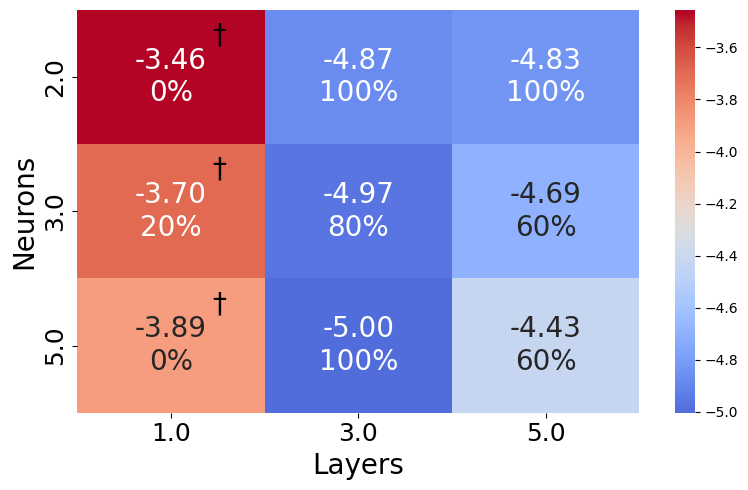

In [550]:
threshold = (1 / 140**2)

# =======================
# 1) Tabela com a MÉDIA
# =======================
pivot = df_class.pivot_table(
    index="hidden",
    columns="blocks",
    values=LOSS_COLUMN,
    aggfunc="median"
)

# log10 dos valores
pivot_log = np.log10(pivot)

# =======================
# 2) Tabela com % de CONVERGÊNCIA
#    (fração de runs com loss < threshold)
# =======================
conv_pivot = (
    df_class
    .groupby(["hidden", "blocks"])[LOSS_COLUMN]
    .apply(lambda x: 100 * np.mean(x < threshold))
    .unstack("blocks")
)

# =======================
# 3) Matriz de strings para o annot
#    "valor\nXX%"
# =======================
annot = np.empty_like(pivot_log.values, dtype=object)

for i, h in enumerate(pivot.index):
    for j, b in enumerate(pivot.columns):
        val = pivot_log.loc[h, b]
        conv = conv_pivot.loc[h, b] if (h in conv_pivot.index and b in conv_pivot.columns) else np.nan
        if np.isnan(conv):
            annot[i, j] = f"{val:.2f}\n-"
        else:
            annot[i, j] = f"{val:.2f}\n{conv:.0f}%"

# log10 do threshold para centralizar o mapa
thr_log = np.log10(threshold)

plt.figure(figsize=(8,5))
ax = sns.heatmap(
    pivot_log,
    annot=annot,
    fmt="",              # importante: usamos strings prontas
    cmap="coolwarm",
    center=thr_log,
    annot_kws={"size": 20},
)
ax.tick_params(axis='both', which='major', labelsize=18)
#plt.title(f"log10(MSE normalizado) — threshold = {threshold}")
plt.ylabel("Neurons", fontsize=20)
plt.xlabel("Layers", fontsize=20)

# === adicionar '†' no canto superior direito das células acima do threshold ===
for i in range(pivot.shape[0]):        # linhas
    for j in range(pivot.shape[1]):    # colunas
        if pivot.iloc[i, j] > threshold:
            ax.text(
                j + 0.72,   # x deslocado para o canto superior direito
                i + 0.25,   # y deslocado levemente para cima
                "$\\dagger$",
                color="black",
                fontsize=20,
                fontweight="bold"
            )

plt.tight_layout()
plt.show()


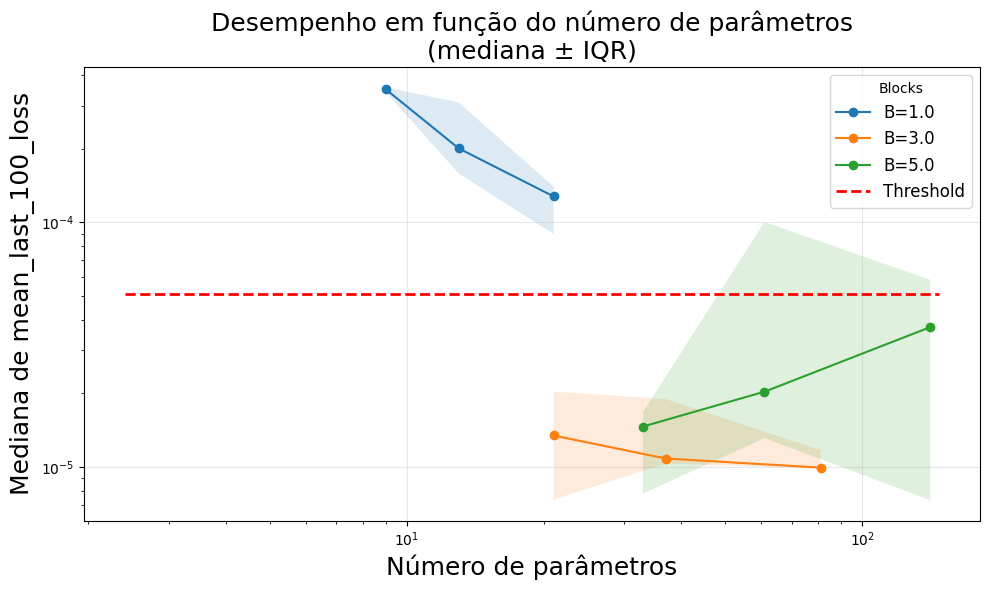

In [551]:
# ======================================================
# 1) AGRUPAMENTO POR (blocks, num_params)
#    -> mediana
#    -> IQR (Q1 e Q3)
# ======================================================

df_stats = df_class.groupby(["blocks", "num_params"])[LOSS_COLUMN].agg(
    median = "median",
    q1     = lambda x: np.percentile(x, 25),
    q3     = lambda x: np.percentile(x, 75)
).reset_index()

# limites inferior/superior da banda
df_stats["lower"] = df_stats["q1"]
df_stats["upper"] = df_stats["q3"]

# evitar valores negativos em escala log
df_stats["lower"] = df_stats["lower"].clip(lower=1e-12)


# ======================================================
# 2) PLOT — cada valor de blocks vira uma linha
# ======================================================

plt.figure(figsize=(10,6))

blocks_values = sorted(df_stats["blocks"].unique())

for L in blocks_values:
    sub = df_stats[df_stats["blocks"] == L].sort_values("num_params")

    x = sub["num_params"].values
    y = sub["median"].values
    low = sub["lower"].values
    upp = sub["upper"].values

    # linha + banda IQR
    plt.plot(x, y, marker="o", label=f"B={L}")
    plt.fill_between(x, low, upp, alpha=0.15)

xmin, xmax = plt.xlim()

plt.hlines(
    y=threshold,
    xmin=xmin,
    xmax=xmax,
    colors='r',
    linestyles='--',
    linewidth=2,
    label='Threshold'
)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Número de parâmetros", fontsize=18)
plt.ylabel(f"Mediana de {LOSS_COLUMN}", fontsize=18)
plt.title("Desempenho em função do número de parâmetros\n(mediana ± IQR)", fontsize=18)
plt.legend(title="Blocks", fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


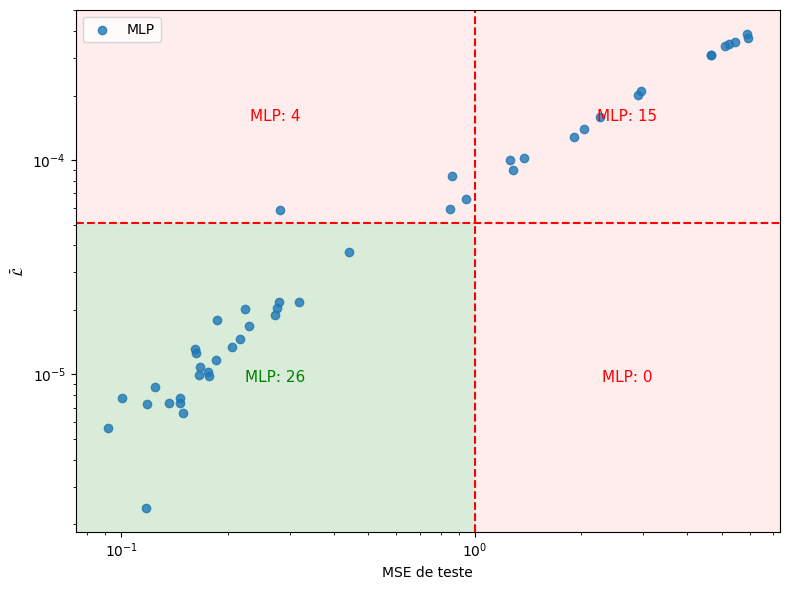

In [552]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# ==========================
# CONFIGURAÇÕES
# ==========================
MSE_COLUMN = "mse_teste_desnormalizado"   # ajuste se o nome for outro
# LOSS_COLUMN já deve estar definido no seu código

# threshold em x e y
tx = 1.0                    # threshold em MSE
ty = 1 / 140**2             # threshold em loss

# -----------------------------
# dados: um único modelo (df_class)
# -----------------------------
x = df_class[MSE_COLUMN].values
y = df_class[LOSS_COLUMN].values

# -----------------------------
# função p/ contagem de quadrantes
# -----------------------------
def quadrant_counts(x, y, tx, ty):
    x = np.asarray(x); y = np.asarray(y)
    return {
        "Q1": np.sum((x >= tx) & (y >= ty)),  # cima-direita
        "Q2": np.sum((x <  tx) & (y >= ty)),  # cima-esquerda
        "Q3": np.sum((x <  tx) & (y <  ty)),  # baixo-esquerda (região boa)
        "Q4": np.sum((x >= tx) & (y <  ty)),  # baixo-direita
    }

cnt = quadrant_counts(x, y, tx, ty)

# -----------------------------
# plot
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(x, y, label="MLP", alpha=0.8)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel("MSE de teste")
ax.set_ylabel(r"$\bar{\mathcal{L}}$")

# linhas de threshold
ax.axhline(ty, color='red', linestyle='--', linewidth=1.5)
ax.axvline(tx, color='red', linestyle='--', linewidth=1.5)

# limites (depois de plottar e setar log!)
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

# -----------------------------
# quadrantes com Rectangle
# -----------------------------
# quadrante bom (baixo-esquerda) – verde
ax.add_patch(Rectangle(
    (x_min, y_min),           # canto inferior esquerdo
    tx - x_min,               # largura
    ty - y_min,               # altura
    facecolor='green', alpha=0.15, zorder=0
))

# cima-esquerda – vermelho claro
ax.add_patch(Rectangle(
    (x_min, ty),
    tx - x_min,
    y_max - ty,
    facecolor='red', alpha=0.07, zorder=0
))

# baixo-direita – vermelho claro
ax.add_patch(Rectangle(
    (tx, y_min),
    x_max - tx,
    ty - y_min,
    facecolor='red', alpha=0.07, zorder=0
))

# cima-direita – vermelho claro
ax.add_patch(Rectangle(
    (tx, ty),
    x_max - tx,
    y_max - ty,
    facecolor='red', alpha=0.07, zorder=0
))

# garantir que limites não mudem
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# -----------------------------
# posições dos textos (meio geométrico em log)
# -----------------------------
def mid_log(a, b):
    return 10**((np.log10(a) + np.log10(b)) / 2)

xL = mid_log(x_min, tx)
xR = mid_log(tx,   x_max)
yB = mid_log(y_min, ty)
yT = mid_log(ty,    y_max)

# baixo-esquerda (Q3) – verde (região boa)
ax.text(
    xL, yB,
    f"MLP: {cnt['Q3']}",
    color='green', fontsize=11, ha='center', va='center'
)

# cima-esquerda (Q2) – vermelho
ax.text(
    xL, yT,
    f"MLP: {cnt['Q2']}",
    color='red', fontsize=11, ha='center', va='center'
)

# baixo-direita (Q4) – vermelho
ax.text(
    xR, yB,
    f"MLP: {cnt['Q4']}",
    color='red', fontsize=11, ha='center', va='center'
)

# cima-direita (Q1) – vermelho
ax.text(
    xR, yT,
    f"MLP: {cnt['Q1']}",
    color='red', fontsize=11, ha='center', va='center'
)

ax.legend()
plt.tight_layout()
plt.show()


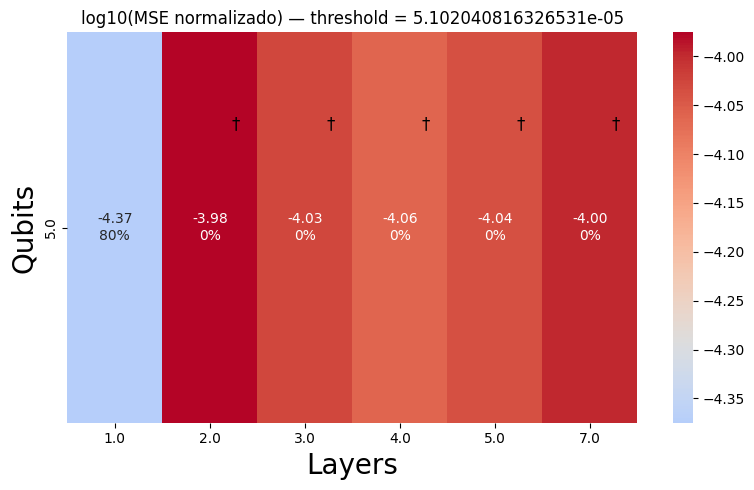

In [553]:
threshold = (1 / 140**2)

# =======================
# 1) Tabela com a MÉDIA
# =======================
pivot = df_quantum.pivot_table(
    index="n_qubits",
    columns="n_layers",
    values=LOSS_COLUMN,
    aggfunc="median"
)

# log10 dos valores
pivot_log = np.log10(pivot)

# =======================
# 2) Tabela com % de CONVERGÊNCIA
#    (fração de runs com loss < threshold)
# =======================
conv_pivot = (
    df_quantum
    .groupby(["n_qubits", "n_layers"])[LOSS_COLUMN]
    .apply(lambda x: 100 * np.mean(x < threshold))
    .unstack("n_layers")
)

# =======================
# 3) Matriz de strings para o annot
#    "valor\nXX%"
# =======================
annot = np.empty_like(pivot_log.values, dtype=object)

for i, h in enumerate(pivot.index):
    for j, b in enumerate(pivot.columns):
        val = pivot_log.loc[h, b]
        conv = conv_pivot.loc[h, b] if (h in conv_pivot.index and b in conv_pivot.columns) else np.nan
        if np.isnan(conv):
            annot[i, j] = f"{val:.2f}\n-"
        else:
            annot[i, j] = f"{val:.2f}\n{conv:.0f}%"

# log10 do threshold para centralizar o mapa
thr_log = np.log10(threshold)

plt.figure(figsize=(8,5))
ax = sns.heatmap(
    pivot_log,
    annot=annot,
    fmt="",              # importante: usamos strings prontas
    cmap="coolwarm",
    center=thr_log,
)

plt.title(f"log10(MSE normalizado) — threshold = {threshold}")
plt.ylabel("Qubits", fontsize=20)
plt.xlabel("Layers", fontsize=20)

# === adicionar '†' no canto superior direito das células acima do threshold ===
for i in range(pivot.shape[0]):        # linhas
    for j in range(pivot.shape[1]):    # colunas
        if pivot.iloc[i, j] > threshold:
            ax.text(
                j + 0.72,   # x deslocado para o canto superior direito
                i + 0.25,   # y deslocado levemente para cima
                "$\\dagger$",
                color="black",
                fontsize=12,
                fontweight="bold"
            )

plt.tight_layout()
plt.show()


In [554]:
# pega um par qualquer (primeiro da tabela)
h = pivot.index[0]          # um valor de n_qubits
b = pivot.columns[0]        # um valor de n_layers

print(f"\n>>> Checando célula (qubits={h}, layers={b})")

# --- valores brutos de loss nesse par ---
vals_q = df_quantum[
    (df_quantum["n_qubits"] == h) &
    (df_quantum["n_layers"] == b)
][LOSS_COLUMN].values

print("loss brutos (df_quantum):", vals_q)

# mediana calculada diretamente
med_manual = np.median(vals_q)
print("mediana manual:", med_manual)
print("mediana no pivot:", pivot.loc[h, b])

# --- se quiser calcular também a % de convergência nesse mesmo conjunto: ---
conv_manual = 100 * np.mean(vals_q < threshold)
print(f"% convergência manual (df_quantum): {conv_manual:.1f}%")

# se conv_pivot tiver mesma indexação de h, b:
if (h in conv_pivot.index) and (b in conv_pivot.columns):
    print("valor em conv_pivot:", conv_pivot.loc[h, b])
else:
    print("par (h,b) não existe em conv_pivot (índices diferentes).")



>>> Checando célula (qubits=5.0, layers=1.0)
loss brutos (df_quantum): [4.21806009e-05 4.05639129e-05 1.69361982e-05 1.82861112e-04
 4.39924621e-05]
mediana manual: 4.218060090352082e-05
mediana no pivot: 4.218060090352082e-05
% convergência manual (df_quantum): 80.0%
valor em conv_pivot: 80.0


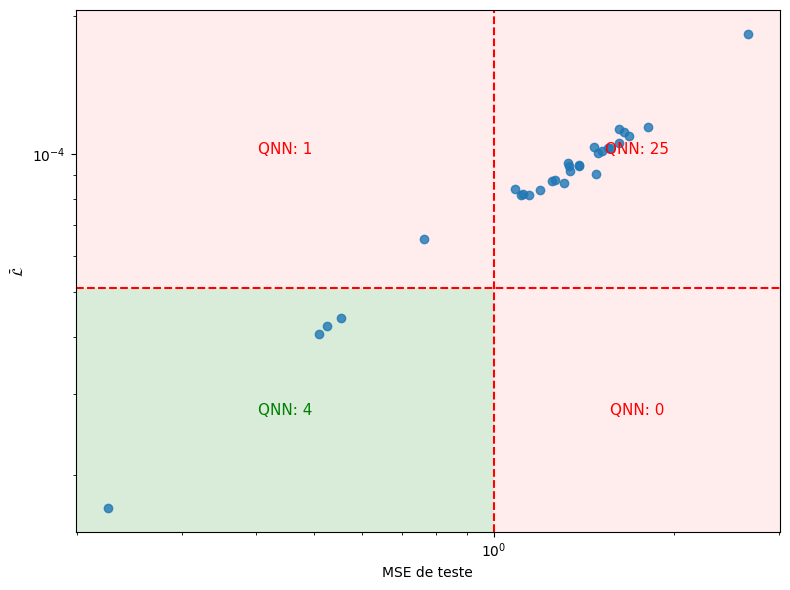

In [555]:
# ==========================
# CONFIGURAÇÕES
# ==========================
MSE_COLUMN = "mse_teste_desnormalizado"   # ajuste se o nome for outro
# LOSS_COLUMN já deve estar definido no seu código

# threshold em x e y
tx = 1.0                    # threshold em MSE
ty = 1 / 140**2             # threshold em loss

# -----------------------------
# dados: um único modelo (df_class)
# -----------------------------
x = df_quantum[MSE_COLUMN].values
y = df_quantum[LOSS_COLUMN].values

# -----------------------------
# função p/ contagem de quadrantes
# -----------------------------

cnt = quadrant_counts(x, y, tx, ty)

# -----------------------------
# plot
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(x, y, label="MLP", alpha=0.8)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel("MSE de teste")
ax.set_ylabel(r"$\bar{\mathcal{L}}$")

# linhas de threshold
ax.axhline(ty, color='red', linestyle='--', linewidth=1.5)
ax.axvline(tx, color='red', linestyle='--', linewidth=1.5)

# limites (depois de plottar e setar log!)
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

# -----------------------------
# quadrantes com Rectangle
# -----------------------------
# quadrante bom (baixo-esquerda) – verde
ax.add_patch(Rectangle(
    (x_min, y_min),           # canto inferior esquerdo
    tx - x_min,               # largura
    ty - y_min,               # altura
    facecolor='green', alpha=0.15, zorder=0
))

# cima-esquerda – vermelho claro
ax.add_patch(Rectangle(
    (x_min, ty),
    tx - x_min,
    y_max - ty,
    facecolor='red', alpha=0.07, zorder=0
))

# baixo-direita – vermelho claro
ax.add_patch(Rectangle(
    (tx, y_min),
    x_max - tx,
    ty - y_min,
    facecolor='red', alpha=0.07, zorder=0
))

# cima-direita – vermelho claro
ax.add_patch(Rectangle(
    (tx, ty),
    x_max - tx,
    y_max - ty,
    facecolor='red', alpha=0.07, zorder=0
))

# garantir que limites não mudem
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# -----------------------------
# posições dos textos (meio geométrico em log)
# -----------------------------
def mid_log(a, b):
    return 10**((np.log10(a) + np.log10(b)) / 2)

xL = mid_log(x_min, tx)
xR = mid_log(tx,   x_max)
yB = mid_log(y_min, ty)
yT = mid_log(ty,    y_max)

# baixo-esquerda (Q3) – verde (região boa)
ax.text(
    xL, yB,
    f"QNN: {cnt['Q3']}",
    color='green', fontsize=11, ha='center', va='center'
)

# cima-esquerda (Q2) – vermelho
ax.text(
    xL, yT,
    f"QNN: {cnt['Q2']}",
    color='red', fontsize=11, ha='center', va='center'
)

# baixo-direita (Q4) – vermelho
ax.text(
    xR, yB,
    f"QNN: {cnt['Q4']}",
    color='red', fontsize=11, ha='center', va='center'
)

# cima-direita (Q1) – vermelho
ax.text(
    xR, yT,
    f"QNN: {cnt['Q1']}",
    color='red', fontsize=11, ha='center', va='center'
)

#ax.legend()
plt.tight_layout()
plt.show()


In [556]:
df_hybrid.groupby(["hidden", "blocks",  "n_layers"]).size()


hidden  blocks  n_layers
2.0     1.0     1.0         5
                3.0         5
                5.0         4
5.0     3.0     1.0         1
        5.0     1.0         5
                3.0         5
                5.0         5
dtype: int64


=== Gerando heatmap para n_layers = 1.0 ===


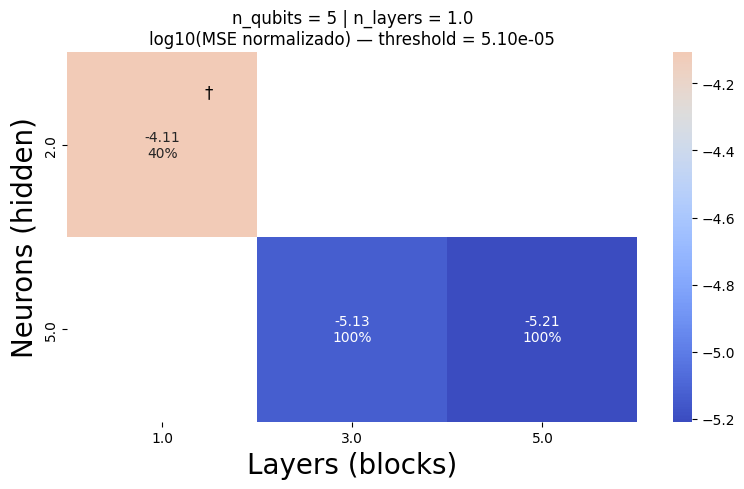


=== Gerando heatmap para n_layers = 3.0 ===


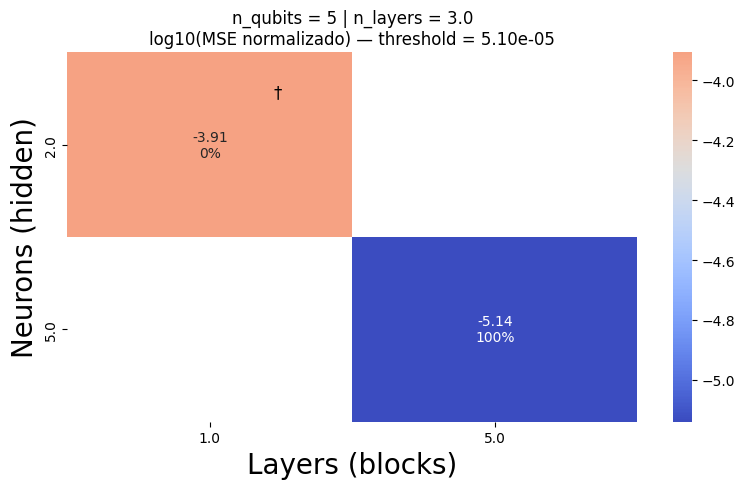


=== Gerando heatmap para n_layers = 5.0 ===


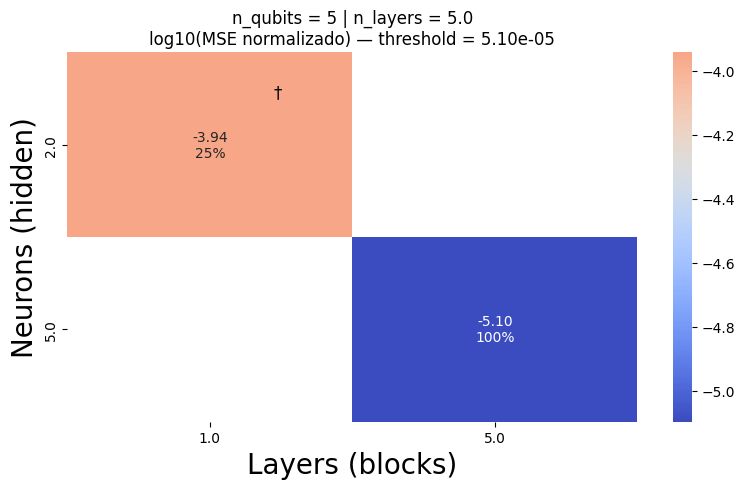

In [557]:
nq_fix = 5     # fixado
threshold = (1 / 140**2)

# -------------------------------
# 1. valores de layers disponíveis
# -------------------------------
all_layers = sorted(df_hybrid["n_layers"].unique())

# -------------------------------
# 2. Loop para cada n_layers
# -------------------------------
for nl_fix in all_layers:

    print(f"\n=== Gerando heatmap para n_layers = {nl_fix} ===")

    # =======================================
    # Filtra só o conjunto de qubits e layers
    # =======================================
    df_q = df_hybrid[
        (df_hybrid["n_qubits"] == nq_fix) &
        (df_hybrid["n_layers"] == nl_fix)
    ].copy()

    if df_q.empty:
        print(f"Sem dados para n_layers={nl_fix}")
        continue

    # =======================================
    # Tabela com a MÉDIA
    # =======================================
    pivot = df_q.pivot_table(
        index="hidden",
        columns="blocks",
        values=LOSS_COLUMN,
        aggfunc="mean"
    )

    pivot_log = np.log10(pivot)

    # =======================================
    # % de convergência
    # =======================================
    conv_pivot = (
        df_q
        .groupby(["hidden", "blocks"])[LOSS_COLUMN]
        .apply(lambda x: 100 * np.mean(x < threshold))
        .unstack("blocks")
    )

    # =======================================
    # Construção das anotações log10 + %
    # =======================================
    annot = np.empty_like(pivot_log.values, dtype=object)

    for i, h in enumerate(pivot.index):
        for j, b in enumerate(pivot.columns):
            val = pivot_log.loc[h, b]
            conv = (
                conv_pivot.loc[h, b]
                if (h in conv_pivot.index and b in conv_pivot.columns)
                else np.nan
            )
            if np.isnan(conv):
                annot[i, j] = f"{val:.2f}\n-"
            else:
                annot[i, j] = f"{val:.2f}\n{conv:.0f}%"

    thr_log = np.log10(threshold)

    # =======================================
    # Plota o HEATMAP
    # =======================================
    plt.figure(figsize=(8,5))
    ax = sns.heatmap(
        pivot_log,
        annot=annot,
        fmt="",
        cmap="coolwarm",
        center=thr_log,
    )

    plt.title(f"n_qubits = {nq_fix} | n_layers = {nl_fix}\nlog10(MSE normalizado) — threshold = {threshold:.2e}")
    plt.ylabel("Neurons (hidden)", fontsize=20)
    plt.xlabel("Layers (blocks)", fontsize=20)

    # marca † se > threshold
    for i in range(pivot.shape[0]):        # linhas
        for j in range(pivot.shape[1]):    # colunas
            if pivot.iloc[i, j] > threshold:
                ax.text(
                    j + 0.72,
                    i + 0.25,
                    "$\\dagger$",
                    color="black",
                    fontsize=12,
                    fontweight="bold"
                )

    plt.tight_layout()
    plt.show()


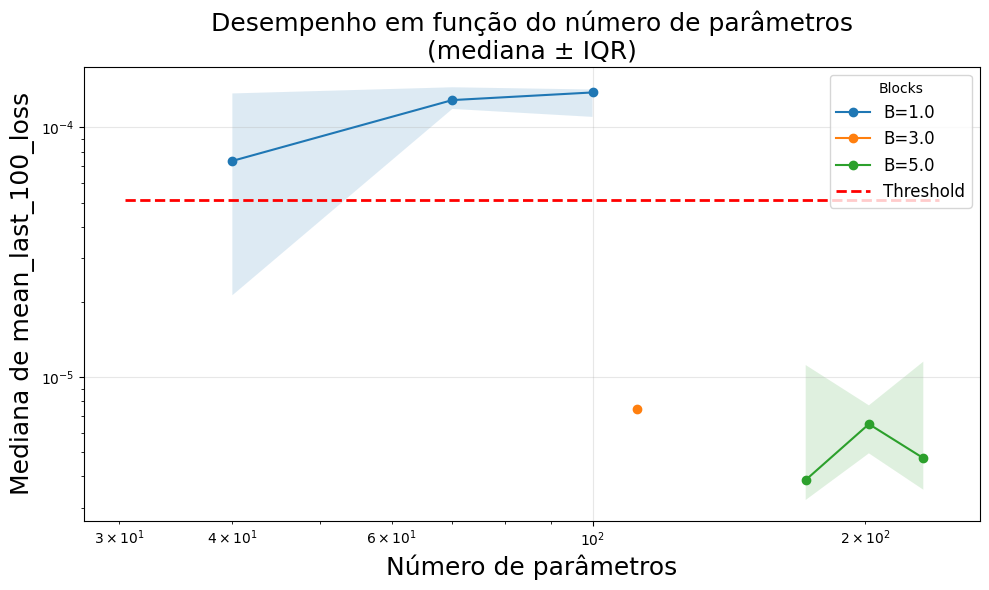

In [558]:
# ======================================================
# 1) AGRUPAMENTO POR (blocks, num_params)
#    -> mediana
#    -> IQR (Q1 e Q3)
# ======================================================

df_stats = df_hybrid.groupby(["blocks", "num_params", "n_layers"])[LOSS_COLUMN].agg(
    median = "median",
    q1     = lambda x: np.percentile(x, 25),
    q3     = lambda x: np.percentile(x, 75)
).reset_index()

# limites inferior/superior da banda
df_stats["lower"] = df_stats["q1"]
df_stats["upper"] = df_stats["q3"]

# evitar valores negativos em escala log
df_stats["lower"] = df_stats["lower"].clip(lower=1e-12)


# ======================================================
# 2) PLOT — cada valor de blocks vira uma linha
# ======================================================

plt.figure(figsize=(10,6))

blocks_values = sorted(df_stats["blocks"].unique())

for L in blocks_values:
    sub = df_stats[df_stats["blocks"] == L].sort_values("num_params")

    x = sub["num_params"].values
    y = sub["median"].values
    low = sub["lower"].values
    upp = sub["upper"].values

    # linha + banda IQR
    plt.plot(x, y, marker="o", label=f"B={L}")
    plt.fill_between(x, low, upp, alpha=0.15)

xmin, xmax = plt.xlim()

plt.hlines(
    y=threshold,
    xmin=xmin,
    xmax=xmax,
    colors='r',
    linestyles='--',
    linewidth=2,
    label='Threshold'
)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Número de parâmetros", fontsize=18)
plt.ylabel(f"Mediana de {LOSS_COLUMN}", fontsize=18)
plt.title("Desempenho em função do número de parâmetros\n(mediana ± IQR)", fontsize=18)
plt.legend(title="Blocks", fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
